---

# GridAPPS-D Application Structure

__2) Start a simulation in the GridAPPS-D Viz:__

The GridAPPS-D API calls covered in this lesson need to be passed to an active simulation. For the purposes of this tutorial, we will use the GridAPPS-D Viz at [localhost:8080](http://localhost:8080/) to start a simulation of the IEEE 123 Node model with a 3600 sec simulation time. 

The steps for starting a simulation were covered in [Using GridAPPS-D Viz](../installation/1.5--Lesson-1.5--Using-GridAPPS-D-Viz.ipynb#Creating-a-Simulation). 

After starting the simulation, paste the simulation_id into the code block below by clicking on the simulation_id. This will automatically copy the simulation_id to your computer's clipboard.

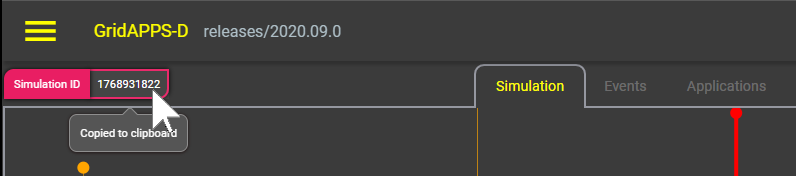

When your application is containerized in Docker and registered with the GridAPPS-D Platform using the docker-compose file, the simulation_id and feeder model mRID as passed as part of the application start call. For this notebook, that information needs to be copied and pasted into the first code block below. 

---

# 1. Application Structure

## Application Structure

The structure of a GridAPPS-D application can be broken into nine sections:

* Querying for the power system model
* Querying for measurement MRIDs
* Querying for weather data (if needed)
* Configuring parallel simulations (if needed)
* App core algorithm & measurement processing
* Subscribing to simulation output
* Publishing equipment commands
* Querying historical & timeseries data
* Subscribing and publishing to logs

Each of these task sections within an application are explained below with sample code that can interact with a simulation running on the GridAPPS-D platform.

## Connecting to GridAPPS-D Platform

Prior to running any of the API calls or other core application code, the application needs to establish a secure connection with the GridAPPS-D platform.

In [ ]:
# Import GridAPPSD-Python Library:
from gridappsd import GridAPPSD

# When developing locally, paste Simulation ID into this variable
# When running inside docker, this is passed automatically by platform
viz_simulation_id = "1093527122"

# Simulation running on IEEE 123 node model:
model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"

In [ ]:
# Set environment variables - when developing, put environment variable in ~/.bashrc file or export in command line
# export GRIDAPPSD_USER=system
# export GRIDAPPSD_PASS=manager

import os # Set username a
os.environ['GRIDAPPSD_USER'] = 'tutorial_user'
os.environ['GRIDAPPSD_PASS'] = '12345!'

# Connect to GridAPPS-D Platform
gapps = GridAPPSD(viz_simulation_id)
assert gapps.connected

---

## Querying for the Power System Model

The first portion of a GridAPPS-D application is series of queries to the PowerGrid Models API to obtain information about the power system model. 

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Blazegraph database and create a set of local variables that contain the information needed by the app to run its internal code. 

An application will query for the various pieces of power system equipment relevant to its objective (e.g. a VVO app will be interested in regulators and capacitors, while a FLISR app will be interested in switches and reclosers present in the model). The query will typically include requests for information about the names, location, mRIDS, and electrical parameters for the various pieces of equipment needed by the application.. 

### Model Query Information flow

The figure below shows the information flow involved in making a query for the power system model.

The query is sent using `gapps.get_response(topic, message)` on a queue channel (explained in [API Communication Channels](../api_usage/3.1--Lesson-3.1--API-Communication-Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

![Query-for-power-system-model](images/2.4/01_query_model.png)

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Using the PowerGrid Models API](../api_usage/3.3--Lesson-3.3--Using-the-PowerGrid-Models-API.ipynb). 

The application then passes the query through the PowerGrid Models API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the data managers, which obtain the desired information from the Blazegraph Database. 

__GridAPPS-D Platform responds to Application query__

The data managers then publish the response from the Blazegraph Database to the appropriate queue channel. The PowerGrid Models API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### Model Query Sample App code
Below is a sample query of how the application will use the PowerGrid Models API to query for the details associated for all the switches in the feeder. 

In [ ]:
from gridappsd import topics as t

message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_DICT",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
switch_dict = response_obj["data"]

# Filter to get mRID for switch SW2:
for index in switch_dict:
    if index["IdentifiedObject.name"] == 'sw2':
        sw_mrid = index["IdentifiedObject.mRID"]

print(switch_dict[0]) # Print dictionary for first switch

print('mRID of sw2 is ',sw_mrid)

---

# 3. Querying for Measurement mRIDs

## Querying for Measurement mRIDs

The next portion of a GridAPPS-D application is series of queries to the PowerGrid Models API to obtain information about the measurements associated with various pieces of equipment the application is interested in. Due to structure of the Common Information Model (introduced in [Intro to Common Information Model](../overview/2.6--Lesson-2.6--Common-Information-Model.ipynb)), there exist a separate set of objects associated with the positive-neutral-voltage (PNV), volt-ampere (VA), and position measurements (POS) for each line, transformer, switch, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Blazegraph Database and create a set of local variables that contain the unique mRIDS of each measurement needed by the app to run its internal code. In a subsequent step, the app will use these measurement mRIDs to subscribe to the live streaming data issued by the simulation.


### 3.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on a queue channel (explained in [API Communication Channels](../api_usage/3.1--Lesson-3.1--API-Communication-Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

![Query-for-model-MRIDs](images/2.4/02_query_model_mrids.png)

The figure below shows the information flow involved in making a query for the power system model. 

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Using PowerGrid Models API](../api_usage/3.3--Lesson-3.3--Using-the-PowerGrid-Models-API.ipynb). 

The application then passes the query through the PowerGrid Models API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the data managers, which obtain the desired information from the Blazegraph Database. 

__GridAPPS-D Platform responds to Application query__

The data managers then publish the response from the Blazegraph Database to the appropriate queue channel. The PowerGrid Models API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

Below is a sample query of how the application will use the PowerGrid Models API to query for the measurement mRIDs of all switches in the power system model

In [ ]:
message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message) # Pass query to PowerGrid Models API
measurements_obj = response_obj["data"]

global Pos_obj # Define global python dictionary of position measurements
Pos_obj = [k for k in measurements_obj if k['type'] == 'Pos'] # Filter measurements to just switch positions

print(Pos_obj[0]) # Print switch position measurement mRID for first switch

---

## 4. Querying for Weather Data

The next portion of a GridAPPS-D application is series of queries to the Timeseries API to obtain information about the weather data for the current time, including irradiation, temperature, etc. This information can be used for solar forecasting, load forecasting, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Timeseries Influx Database and create a set of local variables that contain the weather data needed by the app to run its internal code.


### 4.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on the Timeseries queue channel (explained in  [API Communication Channels](../api_usage/3.1--Lesson-3.1--API-Communication-Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

![Query-for-weather](images/2.4/03_query_weather.png)


__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Using the Timeseries API](../api_usage/3.7--Lesson-3.7--Using-the-Timeseries-API.ipynb). 

The application then passes the query through the Timeseries API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Data Managers, which obtain the desired information from the Timeseries Influx Database. 

__GridAPPS-D Platform responds to Application query__

The Data Managers then publish the response from the Timeseries Influx Database to the appropriate queue channel. The Timeseries API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### 4.2. Sample App Code

Below is a sample query to the Timeseries API requesting all weather data between a certain startTime and endTime (given in unix absolute time). The application can then use that weather data to feed its internal forecasting algorithm.

In [ ]:
# Use queryFilter of "startTime" and "endTime"
message = {
    "queryMeasurement":"weather",
    "queryFilter":{"startTime":"1357048800000000",
                   "endTime":"1357048860000000"},
    "responseFormat":"JSON"
}

response_obj = gapps.get_response(t.TIMESERIES, message) # Pass query to Timeseries API 
weather_obj = response_obj["data"]

print(weather_obj[1]) # Print first line of weather data

---

## 5. Configuring a Parallel Simulation

Some applications may choose to run parallel simulations (similar to a digital twin), either within the GridAPPS-D platform or by exporting the model to OpenDSS, GridLAB-D, etc. This is accomplished through one or more queries to the Configuration File API to create a simulation configuration file and/or exported power system model.

The simulation configuration file contains all the necessary info to create a new simulation, including the power system model, date/time, and variations from the default basecase (i.e. re-dispatched DERs and switches that have been opened/closed).

The exported power system model is the entire model as a set of GLM or DSS that can be saved to an external file and then solved with a different power flow solver outside of the GridAPPS-D Platform.

### 5.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on the Configuration File queue channel (explained in [API Communication Channels](../api_usage/3.1--Lesson-3.1--API-Communication-Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

![config-sim-export](images/2.4/04_config_sim_export.png)

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system configuration in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Using the Configuration File API](../api_usage/3.4--Lesson-3.4--Using-the-Configuration-File-API.ipynb) 

The application then passes the query through the Configuration File API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Configuration Manager.

__GridAPPS-D Platform responds to Application query__

The Configuration Manager obtains the CIM XML file for the desired power system model and then converts it to the desired output format with all of the requested changes to the model. The Configuration File API then returns the desired information back to the application as a JSON message (for Y-Bus or partial models) or export the files to the directory specified in the 

### 5.2. Sample App Code

Below is a sample query showing how an application would make a query through the Configuration File API to change all loads to constant current loads, convert the power system model to a set of OpenDSS files, and export them to the directory `/tmp/dsssimulation`.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS All",
    "parameters": {
        "directory": "/tmp/dsssimulation/",
        "model_id": model_mrid,
        "simulation_id": "12345678",
        "simulation_name": "ieee13",
        "simulation_start_time": "1518958800",
        "simulation_duration": "60",
        "simulation_broker_host": "localhost",
        "simulation_broker_port": "61616",
        "schedule_name": "ieeezipload",
        "load_scaling_factor": "1.0",
        "z_fraction": "0.0",
        "i_fraction": "1.0",
        "p_fraction": "0.0",
        "solver_method": "NR" }
}

gapps.get_response(topic, message)

---

## 6. Processing Measurements & App Core Algorithm

The next portion of a GridAPPS-D application is the measurement processing and core algorithm section. This section is built as either a class or function definition with prescribed arguments. Each has its advantages and disadvantages:

* The function-based approach is simpler and easier to implement. However, any parameters obtained from other APIs or methods to be used inside the function currently need to be defined as global variables. 

* The class-based approach is more complex, but also more powerful. It provides greater flexibility in creating additional methods, arguments, etc.

### 6.1 Information Flow

This portion of the application does not communicate directly with the GridAPPS-D platform. 

Instead, the next part of the GridAPPS-D application ([Subscribing to Simulation Output](#7.-Subscribing-to-Simulation-Output)) delivers the simulated SCADA measurement data to the core algorithm function / class definition. The core algorithm processes the data to extract the desired measurements and run its optimization / control agorithm.

![app-core-algorithm](images/2.4/05_app_core_algorithm.png)

__No message from core algorithm to GridAPPS-D Platform__

The core algorithm does not send any API messages to the platform

__No response to core algorithm from GridAPPS-D Platform__

The core algorithm receives its measurement data and other imputs from the subscription object defined next, rather than directly from the GridAPPS-D platform.

### 6.2. Sample App Code

Below is a very simple core algorithm that determines the number of open switches in the model and prints the result for each simulation timestep. The syntax of the function / class definition is described in detail in 

In [ ]:
def demoSubscription1(header, message):
    # Extract time and measurement values from message          
    timestamp = message["message"]["timestamp"]
    meas_value = message["message"]["measurements"]
    
    meas_mrid = list(meas_value.keys()) #obtain list of all mrid from message
    
    # Filter to measurements with value of zero
    open_switches = []
    for index in Pos_obj:
        if index["measid"] in meas_value:
            mrid = index["measid"]
            power = meas_value[mrid]
            if power["value"] == 0:
                open_switches.append(index["eqname"])
    
    # Print message to command line
    print("............")
    print("Number of open switches at time", timestamp, ' is ', len(set(open_switches)))

---

## 7. Subscribing to Simulation Output

The next portion of a GridAPPS-D application is series of queries to the Timeseries API to obtain information about the weather data for the current time, including irradiation, temperature, etc. This information can be used for solar forecasting, load forecasting, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Timeseries Influx Database and create a set of local variables that contain the weather data needed by the app to run its internal code.


### 7.1. Information Flow

The figure below shows the information flow involved in subscribing to the simulation output.

The subscription request is sent using `gapps.subscribe(topic, class/function object)` on the specific Simulation topic channel (explained in [API Communication Channels](../api_usage/3.1--Lesson-3.1--API-Communication-Channels.ipynb)). No immediate response is expected back from the platform. However, after the next simulation timestep, the Platform will continue to deliver a complete set of measurements back to the application for each timestep until the end of the simulation.

![subscribe-to-simulation](images/2.4/06_subscribe_to_sim.png)

__Application passes subscription request to GridAPPS-D Platform__

The subscription request is perfromed by passing the app core algorithm function / class definition to the `gapps.subscribe` method. The application then passes the subscription request through the Simulation API to the topic channel for the particular simulation on the GOSS Message Bus. If the application is authorized to access simulation output, the subscription request is delivered to the Simulation Manager.

__GridAPPS-D Platform delivers published simulation output to Application__

Unlike the previous queries made to the various databases, the GridAPPS-D Platform does not provide any immediate response back to the application. Instead, the Simulation Manager will start delivering measurement data back to the application through the Simulation API at each subsequent timestep until the simulation ends or the application unsubscribes. The measurement data is then passed to the core algorithm class / function, where it is processed and used to run the app's optimization / control algorithms. 

### 7.2. Sample App Code

Below is an example of how an application subscribes to the GridAPPS-D simulation output using the function or class definition created as part of the [Measurement Processing / App Core](#6.-Processing-Measurements-&-App-Core-Algorithm)

In [ ]:
from gridappsd.topics import simulation_output_topic

output_topic = simulation_output_topic(viz_simulation_id)

gapps.subscribe(output_topic, demoSubscription1)

---

## 8. Publishing Equipment Commands

The next portion of a GridAPPS-D App is publsihing equipment control commands based on the optimization results or objectives of the app algorithm. 

Depending on the preference of the developer, this portion can be a separate function definition, or included as part of the main class definition as part of the [Measurement Processing / App Core](#6.-Processing-Measurements-&-App-Core-Algorithm) class definition described earlier.

### 8.1. Information Flow

The figure below outlines information flow involved in publishing equipment commands to the simulation input. 

Unlike the various queries to the databases in the app sections earlier, equipment control commands are passed to the GridAPPS-D API using the `gapps.send(topic, message)` method. No response is expected from the GridAPPS-D platform. 

If the application desires to verify that the equipment control command was received and implemented, it needs to do so by 1) checking for changes in the associated measurements at the next timestep and/or 2) querying the Timeseries Database for historical simulation data associated with the equipment control command.

![publish-commands](images/2.4/07_publish_commands.png)

__Application sends difference message to GridAPPS-D Platform__

First, the application creates a difference message containing the current and desired future control point / state of the particular piece of power system equipment to be controlled. The difference message is a JSON string or equivalant Python dictionary object. The syntax of a difference message is explained in detail in [Publishing Equipment Commands](../api_usage/3.6--Lesson-3.6--Controlling-Simulation-API.ipynb).

The application then passes the query through the Simulation API to the GridAPPS-D Platform, which publishes it on the topic channel for the particular simulation on the GOSS Message Bus. If the app is authenticated and authorized to control equipment, the difference message is delivered to the Simulation Manager. The Simulation Manager then passes the command to the simulation through the Co-Simulation Bridge (either FNCS or HELICS).

__No response from GridAPPS-D Platform back to Application__

The GridAPPS-D Platform does not provide any response back to the application after processing the difference message and implementing the new equipment control setpoint.

### 8.2. Sample App Code

Below is an example of an app code block 

In [ ]:
import time
from gridappsd import DifferenceBuilder
from gridappsd.topics import simulation_input_topic

input_topic = simulation_input_topic(viz_simulation_id)

my_open_diff = DifferenceBuilder(viz_simulation_id)
my_open_diff.add_difference(sw_mrid, "Switch.open", 1, 0) # Open switch given by sw_mrid
open_message = my_open_diff.get_message()

my_close_diff = DifferenceBuilder(viz_simulation_id)
my_close_diff.add_difference(sw_mrid, "Switch.open", 0, 1) # Close switch given by sw_mrid
close_message = my_close_diff.get_message()

while True:
    time.sleep(5)
    gapps.send(input_topic, open_message)
    time.sleep(5)
    gapps.send(input_topic, close_message)

### 8.3. Viewing Application Results in GridAPPS-D Viz

Return to the browser tab in which the GridAPPS-D Simulation is currently running. Switch `sw5` will now be opening and closing every 5 seconds, with the downstream portion of the feeder being de-energized and reconnected with each switch operation. 

The core application algorithm will also reflect this with the printed response alternating between two and three open switches every few timesteps.

---

## 9. Querying Historical & Timeseries Data

The next portion of a GridAPPS-D application is querying historical data from the current and/or previous simulations. 

All simulation output and commands from the current and previous simulations are stored in the Timeseries Database, and can be queried to provide AI/ML training data, verify processing of equipment commands, or 

Note that Timeseries Database data is cleared when the GridAPPS-D Platform is shut down with the ./stop.sh script. It is recommended to copy historical / training data to an external persistent directory using the `docker cp` command, as given in [Docker Shortcuts](../installation/1.6--Lesson-1.6--Docker-Shortcuts.ipynb).

### 9.1. Information Flow

The figure below outlines the information flow involved in querying for historical and timeseries data.

The query is sent using the `gapps.get_response(topic, message)` method on the Timeseries queue channel with a response expected back from the GridAPPS-D platform within the specified timeout period.

![query-timeseries-data](images/2.4/08_query_timeseries.png)


__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Querying Timeseries Data](../api_usage/3.7--Lesson-3.7--Using-the-Timeseries-API.ipynb). 

The application then passes the query through the Timeseries API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Data Managers, which obtain the desired information from the Timeseries Influx Database. 

__GridAPPS-D Platform responds to Application query__

The Data Managers then publish the response from the Timeseries Influx Database to the appropriate queue channel. The Timeseries API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### 9.2. Sample App Code

In [ ]:
import time

start_time = str(int(time.time())-10) # Start query from 10 sec ago
end_time = str(int(time.time()))

# Query for a particular set of measurments
message = {
    "queryMeasurement": "simulation",
    "queryFilter":{"simulation_id": simulation_id,
                   "startTime": start_time,
                   "endTime": end_time,
                   "measurement_mrid": pos_obj},
    "responseFormat":"JSON"
} 

gapps.get_response(t.TIMESERIES, message) # Pass API call

---

## 10. Subscribing and Publishing to Logs

The last portion of an application is subscribing and publishing to logs. This step is extremely useful for 1) informing end users of application behavior and 2) application debugging during development and demonstration.

The The GridAPPS-D Logging API provides an extension of the standard Python logging library and enables applications to subscribe to real-time log messages from a simulation, query previously logged messages from the MySQL database, and publish messages to their either own log or their GridAPPS-D logs.

### 10.1. Information Flow Diagram

The figure below shows the information flow involved in subscribing and publishing to logs. 

![subscribe-publish-to-logs](images/2.4/09_subscribe_publish_logs.png)

### 10.2 Sample App Code

In [ ]:
from gridappsd.topics import simulation_log_topic
log_topic = simulation_log_topic(viz_simulation_id)

def demoLogFunction(header, message):
    timestamp = message["timestamp"]
    log_message = message["logMessage"]
    
    print("Log message received at timestamp ", timestamp, "which reads:")
    print(log_message)
    print("........................")

gapps.subscribe(log_topic, demoLogFunction)

---

![gridappsd-logo](../images/GridAPPS-D_narrow.png)